# Modeling Police Favorability with UCLA Data

In this notebook, I threw a ton of models at the wall to see what would stick. In the end, I discovered that I couldn't manage to get my R<sup>2</sup> score above .27 or so. My best model was the VotingRegressor that ensembled linear regression, lasso, random forest, and gradient boost models for a score of .2794. But even with that best score, the RMSE was .3065; in other words, when trying to predict a value between 0 and 1, my model's predictions are off by an average of .3 or 30%. So the model itself might not be that helpful, but perhaps there is something to learn from the features and their relative importances. The top ten most important features were `age, race_ethnicity_black, household_income, race_ethnicity_white, religion_atheist, fc_smallgov, news_sources_cnn, news_sources_msnbc, household_gun_owner_no, news_sources_npr, education, religion_agnostic, employment_employed,` and `religion_none`. 

## Imports and prep

After importing the various libraries and packages I'm going to use in this section, I split the dataset into training and testing sets, scaled my features, and used MinMaxScaler to put the target variable (police favorability) on a scale of 0 to 1. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv('../data/ucla_cleaned.csv')
df.head()

,group_favorability_the_police,news_sources_facebook,news_sources_cnn,news_sources_msnbc,news_sources_fox,news_sources_network,news_sources_localtv,news_sources_telemundo,news_sources_npr,news_sources_amtalk,...,region_northeast,region_south,region_west,race_ethnicity_asian,race_ethnicity_black,race_ethnicity_native,race_ethnicity_pacific_islander,race_ethnicity_white,household_gun_owner_no,household_gun_owner_yes
0,2.0,1,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1.0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,1.0,1,0,0,1,1,1,0,0,1,...,0,1,0,0,0,0,0,1,1,0
3,1.0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,1.0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [3]:
X = df.drop(columns = 'group_favorability_the_police')
y = df['group_favorability_the_police']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

mm = MinMaxScaler()

y_train = mm.fit_transform(np.array(y_train).reshape(-1, 1))[:,0]
y_test = mm.transform(np.array(y_test).reshape(-1, 1))[:,0]

## Throwing models at the wall and seeing what sticks

In this section, I created a for loop to see which models seemed to be the best fit for this project. I mostly focused on the testing scores when evaluating these, but was also interested in the range of predictions and the pattern of residuals. I moved forward with the four models from the loop with the highest testing scores to experiment further.

KNeighborsRegressor() 

Training score: 0.3692 , Testing score: 0.0567 

Baseline: 2.1831 , Pred mean: 0.2926 , Pred variance: 0.0084


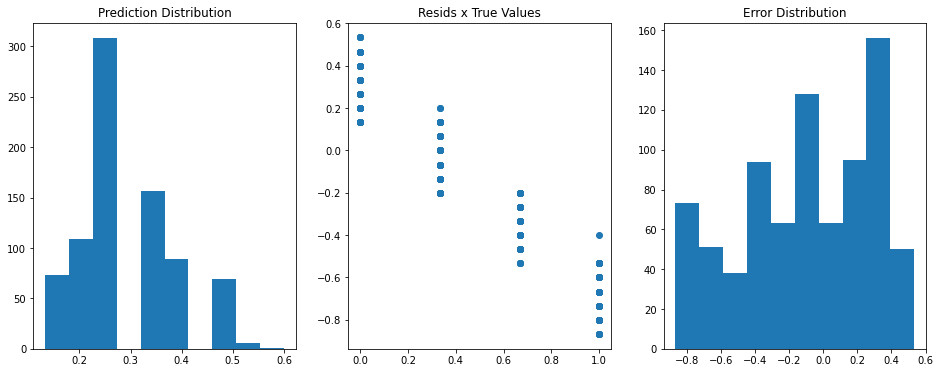

LassoCV() 

Training score: 0.2803 , Testing score: 0.2724 

Baseline: 2.1831 , Pred mean: -3.6339 , Pred variance: 1.8145


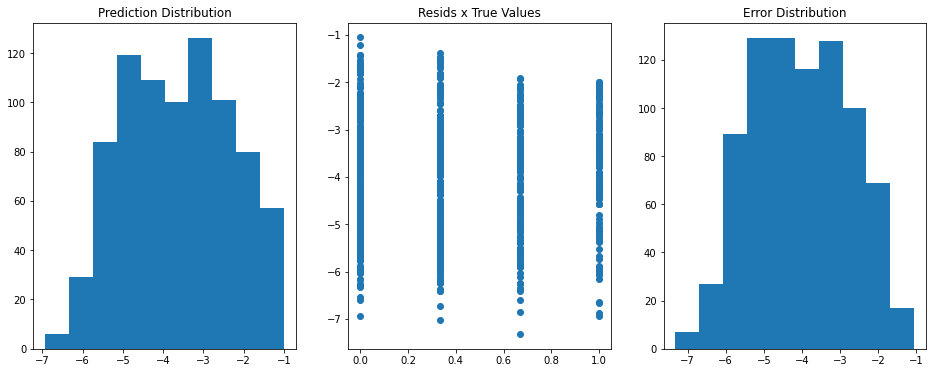

LinearRegression() 

Training score: 0.2962 , Testing score: 0.2725 

Baseline: 2.1831 , Pred mean: 46486042096.0464 , Pred variance: 2.1675373859597877e+20


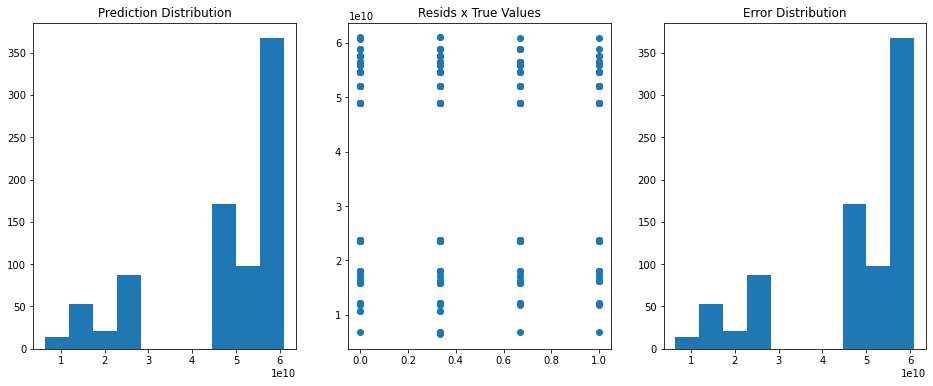

RandomForestRegressor() 

Training score: 0.8946 , Testing score: 0.2417 

Baseline: 2.1831 , Pred mean: 0.3571 , Pred variance: 0.0146


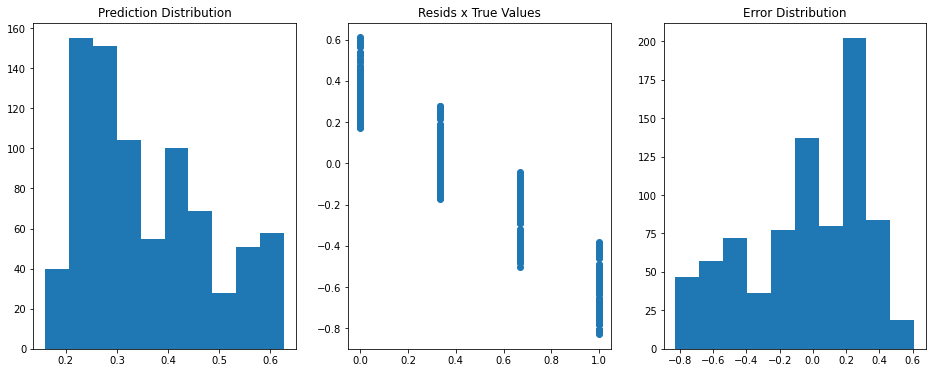

GradientBoostingRegressor() 

Training score: 0.3766 , Testing score: 0.255 

Baseline: 2.1831 , Pred mean: 0.245 , Pred variance: 0.0074


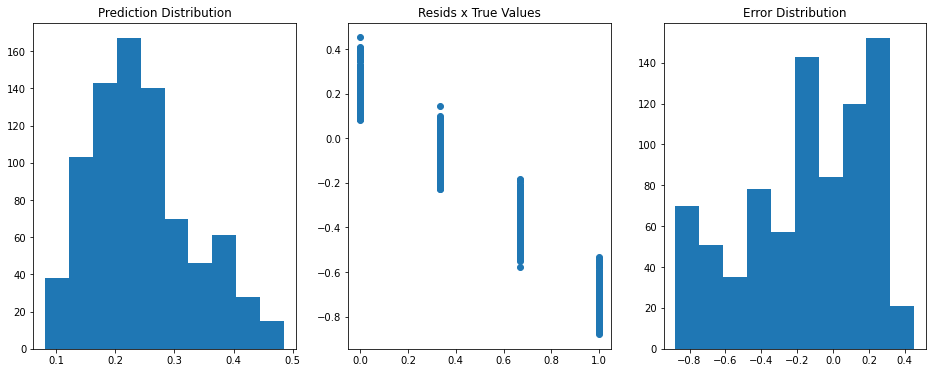

AdaBoostRegressor() 

Training score: 0.2044 , Testing score: 0.1632 

Baseline: 2.1831 , Pred mean: 0.3506 , Pred variance: 0.0009


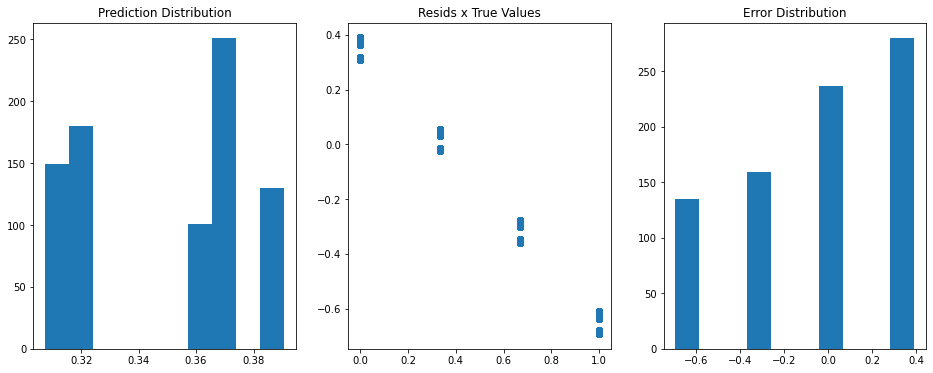

In [4]:
pred_list = []

for model in [KNeighborsRegressor(), LassoCV(), LinearRegression(), RandomForestRegressor(), \
              GradientBoostingRegressor(), AdaBoostRegressor()]:
    model.fit(X_train_sc, y_train)
    print(model, '\n\nTraining score:',round(model.score(X_train_sc,y_train),4),
          ', Testing score:', round(model.score(X_test_sc,y_test),4), '\n')
    preds = model.predict(X_test)
    pred_list.append(preds)
    resids = preds - y_test
    
    print('Baseline:',round(df.group_favorability_the_police.mean(),4), ', Pred mean:', round(preds.mean(),4), \
          ', Pred variance:', round(np.var(preds),4))
    
    plt.figure(figsize = (16,6))
    
    pred = plt.subplot(1,3,1)
    res = plt.subplot(1,3,2)
    err = plt.subplot(1,3,3)
    
    pred.hist(preds)
    pred.set_title('Prediction Distribution')
    
    res.scatter(y_test, resids)
    res.set_title('Resids x True Values')
    
    err.hist(resids)
    err.set_title('Error Distribution')
    
    plt.show()

## Further experimentation
In this section, I define two functions to help extradite the experimentation process in terms of evaluating the success of a model and interpreting the meaning of the coefficients or feature importances. Then I utilize them to narrow down the list of features in an attempt to make my models more generalizable (with some success!).

In [5]:
def scores(model,X=X):
    X_tr = X.loc[X_train.index]
    X_te = X.loc[X_test.index]
    
    sc = StandardScaler()

    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    
    model.fit(X_tr,y_train)
    train_score = model.score(X_tr,y_train)
    test_score = model.score(X_te,y_test)
    
    return print('Training score:',round(train_score,4),
                 ',  Testing score:',round(test_score,4),
                 '\nRMSE:', metrics.mean_squared_error(y_test,model.predict(X_te)) ** 0.5)


def get_feats(model, c_or_i, num_feats,X = X):
    if c_or_i == 'importance':
        coefs = model.feature_importances_
    else:
        coefs = model.coef_
        
    df = pd.DataFrame(abs(coefs), X.columns, columns = ['coefs'])
    df.sort_values('coefs', ascending = False, inplace = True)
    return df.index[:num_feats]

### Grid searched scores prior to feature selection

I removed the GridSearchCV code because it was too much for my computer to run multiple times, but I instantiate the models below with their `best_params_`. Using those grid searched parameters, I gathered the model scores to compare them to the hopefully more generalizable models with fewer features.

In [6]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4,
                           n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

In [7]:
feat_list = []

for model,c_or_i,name in zip([lr,las,rf,gb],['coef','coef','importance','importance'],['LR','Lasso','RF','GB']):
    model.fit(X_train_sc,y_train)
    feat_list.extend(get_feats(model,c_or_i,33))
    print(name)
    scores(model)

LR
Training score: 0.2962 ,  Testing score: 0.2725 
RMSE: 0.30798678033496996
Lasso
Training score: 0.2803 ,  Testing score: 0.2724 
RMSE: 0.30799386643289833
RF
Training score: 0.309 ,  Testing score: 0.2274 
RMSE: 0.3173808939874924
GB
Training score: 0.3767 ,  Testing score: 0.257 
RMSE: 0.3112479841003728


### Grid searched scores after feature selection

Now I'm going to use that narrowed feature list in the same models to see if there is any improvement. I played around with various values for the number of features I extract from each model and settled on 33 (used above) as a good number. It's still a long list of features but this cutoff seemed to have the best outcomes!

In [8]:
# keeping track of the lists of features for all possible cutoffs to make my life easier later

lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4,
                           n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

feat_dict = {}

for i in range(10,50):
    for model,c_or_i,name in zip([lr,las,rf,gb],['coef','coef','importance','importance'],['LR','Lasso','RF','GB']):
        model.fit(X_train_sc,y_train)
        feat_dict[i] = get_feats(model,c_or_i,i)

In [9]:
feats = set(feat_list)

X_narrow = df[feats]
X_train_narrow = X_narrow.loc[X_train.index]
X_test_narrow = X_narrow.loc[X_test.index]

sc = StandardScaler()

X_train_narrow_sc = sc.fit_transform(X_train_narrow)
X_test_narrow_sc = sc.transform(X_test_narrow)

In [10]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4
                           , n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

test_scores = []

for model,name in zip([lr,las,rf,gb],['LR','Lasso','RF','GB']):
    model.fit(X_train_narrow_sc,y_train)
    print('\n'+name)
    test_scores.append(model.score(X_test_narrow_sc,y_test))
    scores(model, X = X[feats])


LR
Training score: 0.2793 ,  Testing score: 0.2555 
RMSE: 0.3115613638256269

Lasso
Training score: 0.2873 ,  Testing score: 0.2746 
RMSE: 0.30753124784123703

RF
Training score: 0.3087 ,  Testing score: 0.2284 
RMSE: 0.31717126451866157

GB
Training score: 0.371 ,  Testing score: 0.2556 
RMSE: 0.3115230506293188


**Some success!** The models seem to be a bit more generalizable now that I've narrowed the features a bit. 

### Trying a voting regressor
I'd like to be able to ensemble these models if possible so I'm going to try throwing these into a VotingRegressor. I played around with various cutoffs and found 44 to be the most successful.

In [11]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 10, min_samples_split = 3, n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

weights = [score/sum(test_scores) for score in test_scores] # using scores from above to weight the models

vote = VotingRegressor([
    ('lr', lr),
    ('las',las),
    ('rf', rf),
    ('gb', gb)],
    weights = weights)

scores(vote, X = X[feat_dict[44]])

Training score: 0.4091 ,  Testing score: 0.2794 
RMSE: 0.30650552794428726


**Yay! Best score yet.** Before I move on to my next experiment, I'm going to see how neural nets perform for this project.

### Trying neural nets

All feats 
Training score: 0.9559 , Testing score: -0.2152 , RMSE: 0.398 

Narrowed 
Training score: 0.8973 , Testing score: -0.1204 , RMSE: 0.3822 



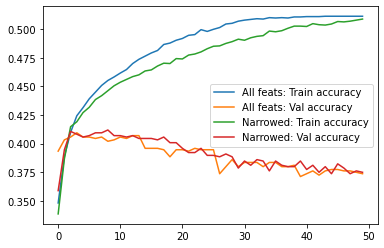

In [12]:
for name, X_tr, X_te in zip(['All feats','Narrowed'],[X_train_sc,X_train_narrow_sc],[X_test_sc,X_test_narrow_sc]):
    nn = Sequential()
    nn.add(Dense(128,
                    input_shape = (X_tr.shape[1],),
                    activation = 'relu'))
    nn.add(Dense(64,activation = 'relu'))
    nn.add(Dense(32,activation = 'relu'))
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

    history = nn.fit(X_tr, y_train, validation_data=(X_te, y_test),
                     epochs=50, batch_size=512, verbose=0)
    
    train_score = round(metrics.r2_score(y_train,nn.predict(X_tr)),4)
    test_score = round(metrics.r2_score(y_test,nn.predict(X_te)),4)
    rmse = round(metrics.mean_squared_error(y_test,nn.predict(X_te)) ** 0.5,4)
    
    print(name,'\nTraining score:',train_score,', Testing score:',test_score, ', RMSE:',rmse,'\n')

    plt.plot(history.history['accuracy'], label=name+': Train accuracy')
    plt.plot(history.history['val_accuracy'], label=name+': Val accuracy')
    plt.legend();

**That uhhhh really didn't work.** Nevermind about the neural nets! 

### Finding unique feature sets for each type of model
Now I'm going to see if there are different cutoffs that work best for each of my four best models by looping through a ton of different possibilities and keeping track of the highest performing parameters.

In [13]:
# establishing variables to overwrite to keep track of my best parameters and make my code more dynamic
best_combo = ('model',0)
best_score = 0

best_lr_combo = 0
best_lr_score = 0

best_las_combo = 0
best_las_score = 0

best_rf_combo = 0
best_rf_score = 0

best_gb_combo = 0
best_gb_score = 0

lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4,
                       n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)
    

In [14]:
# trying all combinations of models and cutoffs and keeping track of the best outcomes for each model
for model,c_or_i,name in zip([lr,las,rf,gb],['coef','coef','importance','importance'],['LR','Lasso','RF','GB']):
    for i in range(10,50):
        feat_list = feat_dict[i]
        X_tr = X[feat_list].loc[X_train.index]
        X_te = X[feat_list].loc[X_test.index]

        sc = StandardScaler()

        X_tr = sc.fit_transform(X_tr)
        X_te = sc.transform(X_te)
        
        model.fit(X_tr,y_train)
        score = model.score(X_te,y_test)
        if score > best_score:
            best_score = score
            best_combo = (name,i)
            
        if name == 'LR' and score > best_lr_score:
            best_lr_score = score
            best_lr_combo = i

        elif name == 'Lasso' and score > best_las_score:
            best_las_score = score
            best_las_combo = i

        elif name == 'RF' and score > best_rf_score:
            best_rf_score = score
            best_rf_combo = i

        elif name == 'GB' and score > best_gb_score:
            best_gb_score = score
            best_gb_combo = i
            
print('Best LR score:', best_lr_score, ', Best LR combo:', best_lr_combo,'\n')
print('Best Lasso score:', best_las_score, ', Best Lasso combo:', best_las_combo,'\n')
print('Best RF score:', best_rf_score, ', Best RF combo:', best_rf_combo,'\n')
print('Best GB score:', best_gb_score, ', Best GB combo:', best_gb_combo,'\n')
print('\nBest score:', best_score, ', Best combo:', best_combo)

Best LR score: 0.27786881196070057 , Best LR combo: 46 

Best Lasso score: 0.2774832581967903 , Best Lasso combo: 46 

Best RF score: 0.2315562549445006 , Best RF combo: 32 

Best GB score: 0.26131826522933477 , Best GB combo: 18 


Best score: 0.27786881196070057 , Best combo: ('LR', 46)


**That helped the individual scores a tiny bit but, like I said, I'd love to ensemble the models if possible.** Since I can't use different features for each model in a voting ensemble, I'm going to make my own. 

### Manual voting regressor model

Below, I use the test scores from above to weight the models, create predictions using the best cutoff for each model, and then calculate a weighted average for each prediction.

In [15]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 10, min_samples_split = 3, n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

test_scores = [best_lr_score,best_las_score,best_rf_score,best_gb_score]
weights = [score/(best_lr_score + best_las_score + best_rf_score + best_gb_score) for score in test_scores]

pred_df = pd.DataFrame()

for model, name, weight, n in zip([lr,las,rf,gb],['LR','Lasso','RF','GB'],weights,                             
    [best_lr_combo,best_las_combo,best_rf_combo,best_gb_combo]):
    
    spaces = ' '*(5-len(name))
    print(name+':',spaces,n,'features')
    
    feats = feat_dict[n]
    X_tr = X[feats].loc[X_train.index]
    X_te = X[feats].loc[X_test.index]

    sc = StandardScaler()
    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    model.fit(X_tr,y_train)
    preds = model.predict(X_te)
    
    pred_df[name] = list(preds * weight)

pred_df['pred'] = sum([pred_df['LR'],pred_df['Lasso'],pred_df['RF'],pred_df['GB']])

print('\nTesting score:',metrics.r2_score(y_test, list(pred_df['pred'])))

LR:     46 features
Lasso:  46 features
RF:     32 features
GB:     18 features

Testing score: 0.2841098815658697


**The best score yet!** Yay! I think this is just about as good as it's going to get.

## Final model selection

So my best model was the manual voting regressor that ensembled linear, lasso, random forest, and gradient boost regression models with 46, 46, 32, and 18 features respectively. Now I'm going to look at the features and their coefficients to interpret the results.

In [16]:
coef_df = pd.DataFrame()
coef_df['feature'] = X.columns

for model, name, c_or_i, n in zip([lr,las,rf,gb],['LR','Lasso','RF','GB'],
                               ['coef','coef','importance','importance'],
                               [best_lr_combo,best_las_combo,best_rf_combo,best_gb_combo]):
    
    feats = feat_dict[n]
    
    model_coef_df = pd.DataFrame()
    model_coef_df['feature'] = feats

    X_tr = X[feats].loc[X_train.index]
    X_te = X[feats].loc[X_test.index]
    
    sc = StandardScaler()
    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    model.fit(X_tr,y_train)
    
    if c_or_i == 'importance':
        model_coef_df[name] = model.feature_importances_
    else: 
        model_coef_df[name] = model.coef_
    
    coef_df = pd.merge(coef_df, model_coef_df, how = 'left', on = 'feature')
    
coef_df.fillna(0,inplace=True)    
coef_df['avg'] = (coef_df['LR'] + coef_df['Lasso'] + coef_df['RF'] + coef_df['GB']) / 4

In [17]:
coef_df.fillna(0,inplace=True)    
coef_df['avg'] = (coef_df['LR'] + coef_df['Lasso'] + coef_df['RF'] + coef_df['GB']) / 4
coef_df['abs_avg'] = abs(coef_df['avg'])

## Top ten features

In [18]:
coef_df.loc[coef_df['abs_avg'] >= 0.01,:].sort_values('abs_avg',ascending=False)[['feature','avg']]


,feature,avg
15,age,0.090897
101,race_ethnicity_black,0.056491
17,household_income,0.034895
104,race_ethnicity_white,0.029954
79,religion_atheist,0.027967
14,fc_smallgov,0.025900
1,news_sources_cnn,0.023466
2,news_sources_msnbc,0.022839
105,household_gun_owner_no,0.022770
7,news_sources_npr,0.021789
